# Course: Apprentissage statistique
## CORO-SIP, LEARN-TP
---
## Enseignants:
 * Dawood ALCHANTI
 * Mathieu LAGRANGE
---

# Recurrent Neural Network part 1: Implementation from scratch.

## 1. Materials

#### 1. In this lab we will consider using google colab: https://colab.research.google.com/notebooks/intro.ipynb#recent=true

#### 2. Press the link above, go to **file** and press **upload notebook**, then chose the file ''Recurrent_Neural_Network_Lab_Part_1''

#### 3. At the beggining of your code, go to Edit, Notebook Setting, and change the configuration to GPU, so  you can use google colab gpus.

## 2. Goal: 

### The objective of this lab part 1 is to:
#### 1. Learn how to implement from scratch the RNN layer using Tensorflow framework.
#### 2. How to use it on Images for classification.

![title](home/user/Documents/Teaching/RNN/Dawood/Code/RNN Lab Datasim and Learn/lab1.png)

In [ ]:

# Image(filename ="home/user/Documents/Teaching/RNN/Dawood/Code/RNN Lab Datasim and Learn/lab1.png", width=100, height=100)

## 3. Implementation: We will rely on Tensorflow Version 1.x 

### Load the dependencies:

In [1]:
# The following command will ensure that we load the tensorflow version 1.15.2
# which we will use for this lab, any other version of 1.x are also applicable.
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.contrib import rnn

In [3]:
# Check if we are using the right version
print('TensorFlow Version: ',tf.__version__)

TensorFlow Version:  1.15.2


In [4]:
# an attempt to turn off all possible warning
import warnings
warnings.filterwarnings('ignore')

### **MNIST Dataset**

It is a dataset of handwritten digits. 
MNIST is kind of benchmark of datasets for deep learning. 
One other reason that we use the MNIST is that it is easily accesible through Tensorflow library.

1. The dataset contains 55,000 examples for training, 5,000 examples for validation and 10,000 examples for testing. 
2. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28x28 image).

#### In this section, we'll write the function which automatically loads the MNIST data and returns it in our desired shape and format. 

We willll simply write a function (load_MNIST_data) which has two mode: 
1. train (which loads the training and validation images and their corresponding labels)
2. test (which loads the test images and their corresponding labels).

In [5]:
# Please read the code to understand what is going on. No action is required.
def load_MNIST_data(mode='train'):
    """
    Function to download and load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test

def Data_Shuffeling(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    """ Iterates over the dataset in batches"""
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### **Load the dataset using the above functions and display the vector sizes**
Now we can use the defined helper function in "train" mode which loads the train and validation images and their corresponding labels.

### Q.1
1. Use the function load_MNIST_data in mode train, make sure you understood and read the functions.
2. replace xxx by your code.

In [6]:
x_train, y_train, x_valid, y_valid = load_MNIST_data(mode='train')
x_test, y_test = load_MNIST_data(mode='test')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Q.2
* Display the size of the training and the validation set.

In [7]:
print("Size of:")
print('Training Set', x_train.shape)   #replace xxx by your code 
print('Valdiation Set', x_valid.shape) #replace xxx by your code 

Size of:
Training Set (55000, 784)
Valdiation Set (5000, 784)


### Q.3 Choose one example randomly from the training set and display its label:
1. Check wether any of the label vectors are One Hot Encoded or not?
2. If Yes, turn it into categorical.

In [8]:
print('Vector: ', y_train[5])
print('The corresponding categorical value of the one Hot Encoded Vector is : ', np.argmax(y_train[5]))

Vector:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
The corresponding categorical value of the one Hot Encoded Vector is :  8


## Data Formate

1. To classify images using a recurrent neural network, we consider every image row as a sequence of pixels.
2. Because MNIST image shape is 28x28 pixels, we will then handle 28 sequences of 28 timesteps for every sample.

### Q.4 Define the following hyper-parameters:

In [9]:
# Data Dimension
num_input = 28          # MNIST data input (image shape: 28x28)
timesteps = 28          # Timesteps
n_classes = 10          # Number of classes, one class per digit

### Q.5  Network Hyper-parameters and configurations:
Let us first define:
1. the number of the hidden units for the RNN: consider 128 units for this lab, at home, you can try to change this value and check the model performance and complexity.
2. the learning rate: consider 0.001 for this lab, at home, you can try to change this value and check the model performance.
3. the number of training epochs: consider 10 epochs for this lab, at home, you can try to change this value and check the model performance.
4. the batch size: consider 100 examples for this lab, at home, you can try to change this value and check the model performance and complexity.
5. the frequency of the displaying the training results (just for visualization): consider 100.

In [10]:
num_hidden_units = 128  # Number of hidden units of the RNN
learning_rate = 0.001 # The optimization initial learning rate
epochs = 20           # Total number of training epochs
batch_size = 100      # Training batch size
display_freq = 100    # Frequency of displaying the training results

### **Functions that initialize the weights and the biases**

In [11]:
# weight and bais wrappers: No action is required. Please try to understand the code before proceeding.
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)
 

# Recurrent Neural Network Layer Implementation

###  Implementation Remarks:
1. The function **recurrent_layer** must take an input x, a 3D tensor, the first entry will represent a batch of rairning examples, the second tensor represent the number of time steps that each example is made of, and the last tensor represent the number of vector size of each input time steps. Remember, here we are takng an image of size hxw=28x28, therefore, here, we consider w=28 as time steps and h=28 as time step feature vector.
2. Use the BasicRNNCell from rnn  as a helper function, look for documentation on how to use it.
3. Use the static_rnn from rnn as a helper function, look for documentation on how to use it.
4. Get the final output with linear activation

### Q.6 Implement RNN and follow the commented instruction

In [12]:
def recurrent_layer(x, weights, biases, timesteps, num_hidden):
    '''
    This function must accept an input variable x, the W and b, the timesteps number, and the number of the hidden units.

      # Prepare data shape to match `rnn` function requirements
      # Current data input shape: (batch_size, timesteps, n_input)
      # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    '''
    # 1. Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input).
    x = tf.unstack(x, timesteps, 1)

    # 2. Define a rnn cell using tensorflow rnn library, use BasicRNNCell.
    rnn_cell = rnn.BasicRNNCell(num_hidden)

    # 3. Get lstm cell final output:
        # If no initial_state is provided, dtype must be specified as float32
        # If no initial cell state is provided, tf will initialize it to zero
        
    states_series, current_state = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # 4. Apply Linear activation, using rnn inner loop last output. 
    return tf.matmul(current_state, weights) + biases
 

# Q.7 Build your Computational Graph

1. Define a placeholder that accept the input and the label, we will use tf.placeholder. Enter the right shapes.

In [13]:
# Placeholders for inputs (x) and outputs(y): 
x = tf.placeholder(tf.float32, shape=[None, timesteps, num_input], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

2. Use the functions weight_variable and bias_variable to define a set of weights [W,b]

In [14]:
# create weight matrix initialized randomely from N~(0, 0.01)
W = weight_variable(shape=[num_hidden_units, n_classes])

# create bias vector initialized as zero
b = bias_variable(shape=[n_classes])

3. Use [W, b] in recurrent_layer function we defined previously to get the rnn output

In [15]:
# Get the RNN ouput
output_logits = recurrent_layer(x, W, b, timesteps, num_hidden_units)
print(output_logits.shape)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 10)


4. Compute the Prediction using Softmax function, you can directly use builtin function from tf.nn

In [16]:
# Compute the prediction using softmax
y_pred = tf.nn.softmax(output_logits)

5. Compute the class predictions: turn the output_logits into categorical by taking the argmax

In [17]:
# Perform Model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

6. Define the model loss function:
    1. we will use the tf.softmax_cross_entropy_with_logits
    2. then we will reduce the mean using  tf.reduce_mean

In [18]:
# Define the loss function,
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



7. Use Adam Optimizer: tf.train.AdamOptimizer over the defined loss

In [19]:
# Define the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)

8. Compute the model performance
    1. Compute the correct prediction 
    2. Compute the total accuracy

In [20]:
# Define the accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(output_logits, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
 

In [21]:
# no changes should be made here, keep it as it is.
init = tf.global_variables_initializer() # Creating the op for initializing all variables 

In [34]:
import time

### **Run a training Session**
1. Train over the training database.
2. Validate over the validation set.
3. Print the loss, train and validation accuracy

In [38]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
start = time.time()
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    
    
    #1. Shuffel the dataset:
    x_train, y_train = Data_Shuffeling(x_train, y_train)  # change xxx by your code
    
    for iteration in range(num_tr_iter):
        global_step += 1
        
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
        x_batch = x_batch.reshape((batch_size, timesteps, num_input))
        
        
        # 2. Run optimization op (backprop)               
        feed_dict_batch = {x: x_batch, y: y_batch}                  #change xxx by your code
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # 3. Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],              #change xxx by your code
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))
    
    # No action to be taken here, keep it as it is.
    # Run validation after every epoch
    feed_dict_valid = {x: x_valid[:1000].reshape((-1, timesteps, num_input)), y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
end = time.time()
print(end-start)

Training epoch: 1
iter   0:	 Loss=2.29,	Training Accuracy=26.0%
iter 100:	 Loss=0.90,	Training Accuracy=74.0%
iter 200:	 Loss=0.55,	Training Accuracy=87.0%
iter 300:	 Loss=0.39,	Training Accuracy=85.0%
iter 400:	 Loss=0.27,	Training Accuracy=95.0%
iter 500:	 Loss=0.22,	Training Accuracy=92.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.26, validation accuracy: 93.8%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.34,	Training Accuracy=92.0%
iter 100:	 Loss=0.37,	Training Accuracy=87.0%
iter 200:	 Loss=0.21,	Training Accuracy=91.0%
iter 300:	 Loss=0.19,	Training Accuracy=95.0%
iter 400:	 Loss=0.32,	Training Accuracy=95.0%
iter 500:	 Loss=0.13,	Training Accuracy=96.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.19, validation accuracy: 95.6%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.16,	Training Accuracy=97

# Generalization Performance over the Test Set

# Helper functions for Visualziations

In [39]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.squeeze(images[i]).reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)

def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)
 

### Computing the Model Performance over the Test Set

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.10, test accuracy: 97.0%
---------------------------------------------------------


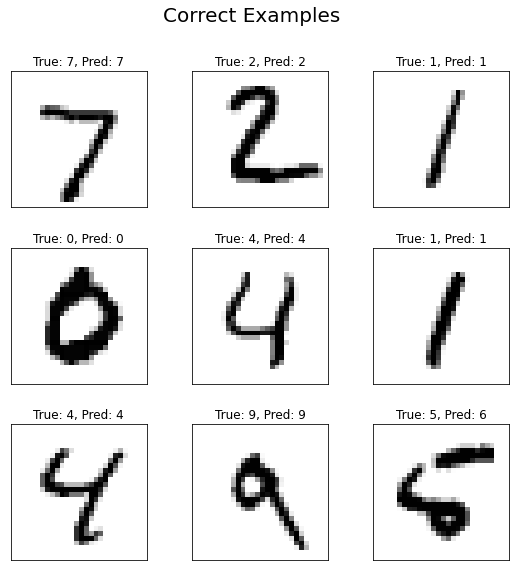

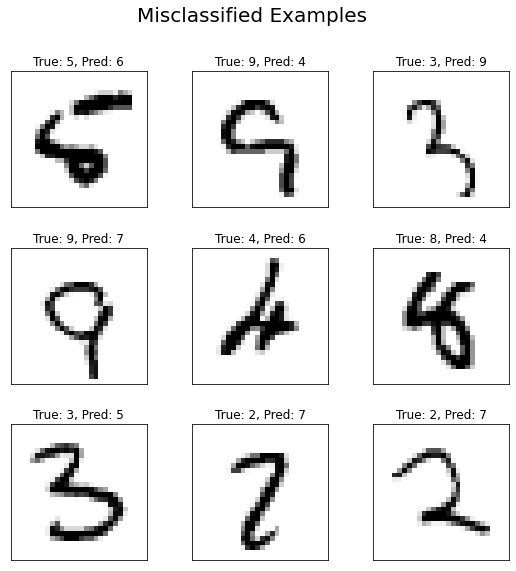

In [40]:
# Test the network (only on 1000 samples) after training
# Accuracy

# Load the test set, use the test mode
x_test, y_test = load_MNIST_data('test')   # Replace xxx by your code
feed_dict_test = {x: x_test[:1000].reshape((-1, timesteps, num_input)), y: y_test[:1000]}

# Compute the test loss and the accuracy:
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)  # Replace xxx by your code
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')


# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true[:1000], cls_pred, title='Misclassified Examples')
plt.show()
 

# Comment on the model performance, please consider the following aspects:
 1. the running time to train the whole model
 2. the performance in term of accuracy
 3. the model complexity
 
 ---
 
 4. Do you think using RNN is advantageous? Why? 
 5. If you are presented with a problem such as Digit Classification, would you directly consider using RNN? If No, what types of Neural Networks would you consider and why?